In [ ]:
!pip install langchain_community
!pip install langchain
!pip install datasets
!pip install faiss-gpu
!pip install sentence-transformers

In [39]:
import warnings
import torch
import pandas as pd
import faiss
import numpy as np
import io
import tqdm
from PIL import Image
from tqdm.auto import tqdm
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode
from langchain_community.embeddings import HuggingFaceEmbeddings
from datasets import load_dataset
from langchain.embeddings import FakeEmbeddings
warnings.filterwarnings("ignore")

In [3]:
fashion_product_dataset = load_dataset("ashraq/fashion-product-images-small",
                                       split="train")
print(len(fashion_product_dataset))

44072


In [4]:
fashion_product_dataset = fashion_product_dataset.to_pandas()
fashion_product_dataset

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
...,...,...,...,...,...,...,...,...,...,...,...
44067,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
44068,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
44069,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
44070,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...


In [5]:
images = fashion_product_dataset['image']

fashion_product_dataset = fashion_product_dataset.drop(columns=["image"])

print(fashion_product_dataset.head())

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  


In [6]:
print(type(fashion_product_dataset))

<class 'pandas.core.frame.DataFrame'>


In [7]:
duplicate_rows = fashion_product_dataset[fashion_product_dataset.duplicated()]
print("Rows : ", len(duplicate_rows))

duplicate_product_names = fashion_product_dataset.duplicated(subset=["productDisplayName"], keep=False)
duplicate_product_names_count = duplicate_product_names.sum()

# Kaç adet aynı ürün ismi olduğunu göster
print("Aynı ürün ismine sahip satır sayısı:", duplicate_product_names_count)

Rows :  0
Aynı ürün ismine sahip satır sayısı: 18360


In [10]:
print(fashion_product_dataset.head())
print(len(fashion_product_dataset))
print("---"*15)
print(images.head())
print(len(images))

      id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  39386    Men        Apparel  Bottomwear        Jeans       Blue  Summer   
2  59263  Women    Accessories     Watches      Watches     Silver  Winter   
3  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
4  53759    Men        Apparel     Topwear      Tshirts       Grey  Summer   

     year   usage                             productDisplayName  
0  2011.0  Casual               Turtle Check Men Navy Blue Shirt  
1  2012.0  Casual             Peter England Men Party Blue Jeans  
2  2016.0  Casual                       Titan Women Silver Watch  
3  2011.0  Casual  Manchester United Men Solid Black Track Pants  
4  2012.0  Casual                          Puma Men Grey T-shirt  
44072
---------------------------------------------
0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1    {'bytes': b'\xff\

In [ ]:
images[305]

In [17]:
BATCH_SIZE = 120
MODEL_NAME = "all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=MODEL_NAME)
#embeddings = FakeEmbeddings(size=512)
embedding_list = []

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [18]:
product_display_names = fashion_product_dataset["productDisplayName"]
for i in tqdm(range(0, len(product_display_names), BATCH_SIZE)):

    batch_names = product_display_names[i:i+BATCH_SIZE]
    batch_embeddings = embeddings.embed_documents(batch_names)
    embedding_list.extend(batch_embeddings)

product_embeddings = np.array(embedding_list).astype("float32")

  0%|          | 0/368 [00:00<?, ?it/s]

In [19]:
n, d = product_embeddings.shape
print(f"Number of vectors: {n}")
print(f"Dimension of each vector: {d}")

Number of vectors: 44072
Dimension of each vector: 384


In [20]:
index = faiss.IndexFlatL2(d)
index.add(product_embeddings)

In [21]:
query = input("Search a product name: ")
query_embedding = embeddings.embed_query(query)
query_embedding = np.array([query_embedding]).astype("float32")

Search a product name: Man jean regular


In [22]:
k = 10
distances, indices = index.search(query_embedding, k)
print(distances, indices)

[[1.0067002 1.0067002 1.0067002 1.0067003 1.0067003 1.0067003 1.008548
  1.012456  1.0124563 1.0333031]] [[ 1662  4653 22690 40484 43679 26157 25690 22136  1777 22300]]


In [26]:
flat_indices = [index for sublist in indices for index in sublist]
product_display_names = np.array(fashion_product_dataset["productDisplayName"])
for name in product_display_names[flat_indices]:
    print(name)

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Navy Blue Jeans
Levis Kids Blue Solid Jean
Levis Kids Blue Solid Jean
French Connection Men Black Jeans


In [ ]:
faiss.write_index(index, "fashion_embeddings")
#index = faiss.read_index("my_index")

In [33]:
images.head()

0    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
1    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
2    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
3    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
4    {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...
Name: image, dtype: object

In [48]:
images[0]["bytes"]

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00d\x00d\x00\x00\xff\xec\x00\x11Ducky\x00\x01\x00\x04\x00\x00\x00\'\x00\x00\xff\xdb\x00C\x00\t\x06\x07\x08\x07\x06\t\x08\x07\x08\n\n\t\x0b\r\x16\x0f\r\x0c\x0c\r\x1b\x14\x15\x10\x16 \x1d"" \x1d\x1f\x1f$(4,$&1\'\x1f\x1f-=-157:::#+?D?8C49:7\xff\xdb\x00C\x01\n\n\n\r\x0c\r\x1a\x0f\x0f\x1a7%\x1f%77777777777777777777777777777777777777777777777777\xff\xc0\x00\x11\x08\x00P\x00<\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\x04\x05\x07\x02\x03\x01\xff\xc4\x002\x10\x00\x02\x01\x03\x02\x04\x04\x05\x04\x01\x05\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\x11\x05\x12\x06\x13!1"AQa\x072q\x81\xa1\x14\x15#\x91R$Bs\xb1\xc2\xff\xc4\x00\x18\x01\x00\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x00\x04\xff\xc4\x00 \x11\x00\x02\x02\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x11\x03\x04\x121\x132Q!A\xff\xda\x00\x0c\x03\x01\x00\x02\x11\x03

In [38]:
print(flat_indices)

[1662, 4653, 22690, 40484, 43679, 26157, 25690, 22136, 1777, 22300]



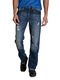
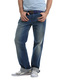
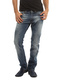
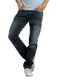
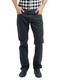
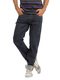
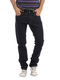
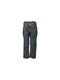
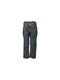
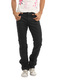

In [50]:
from PIL import Image
from io import BytesIO
import base64
from IPython.display import HTML

closest_images = [Image.open(BytesIO(images[i]['bytes'])) for i in flat_indices]

def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{base64.b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

display_result(closest_images)


In [ ]:
# closest_images = [images[i] for i in flat_indices]

# def display_result(image_batch):
#     figures = []
#     for img in image_batch:
#         b = BytesIO()
#         img.save(b, format='png')
#         figures.append(f'''
#             <figure style="margin: 5px !important;">
#               <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
#             </figure>
#         ''')
#     return HTML(data=f'''
#         <div style="display: flex; flex-flow: row wrap; text-align: center;">
#         {''.join(figures)}
#         </div>
#     ''')

# display_result(closest_images)
